In [ ]:
# Imports

# TODO
# 

In [167]:
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os
import numpy as np
from tensorflow.keras.metrics import BinaryAccuracy, AUC, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Recall
from IPython.display import clear_output

In [2]:
with zipfile.ZipFile('/content/skin_cancer_small.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
# Data exploration - amount of data, size, plotting, dividing into datasets

There are 5 training examples for malignant moles, and 5 examples for bening ones

In test set there are 5 examples for malingant and 5 examples for bening





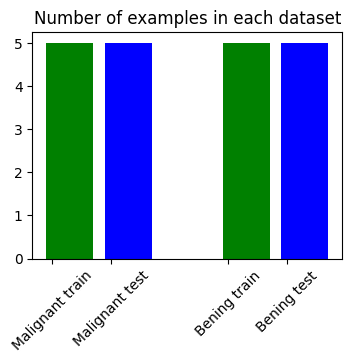

In [123]:
dataset_path = '/content/skin_cancer_small'
train_malignant = os.path.join(dataset_path, 'train', 'malignant')
train_bening = os.path.join(dataset_path, 'train', 'bening')
test_malignant = os.path.join(dataset_path, 'test', 'malignant')
test_bening = os.path.join(dataset_path, 'test', 'bening')
malignant_paths_train = [os.path.join(train_malignant,x) for x in os.listdir(train_malignant)]
bening_paths_train = [os.path.join(train_bening,x) for x in os.listdir(train_bening)]
malignant_paths_test = [os.path.join(test_malignant,x) for x in os.listdir(test_malignant)]
bening_paths_test = [os.path.join(test_bening,x) for x in os.listdir(test_bening)]

print('There are {} training examples for malignant moles, and {} examples for bening ones\n'.format(len(malignant_paths_train), len(bening_paths_train)))
print('In test set there are {} examples for malingant and {} examples for bening\n\n\n'.format(len(malignant_paths_test), len(bening_paths_test)))

# do i want this plot here?
fig, axs = plt.subplots(figsize=(4,3), dpi=100)
axs.bar([0,1,3,4], [len(malignant_paths_train),len(malignant_paths_test),len(bening_paths_train),len(bening_paths_test)],color=['green', 'blue', 'green', 'blue'])
plt.xticks([-0.3,0.7,2.7,3.7], ['Malignant train', 'Malignant test', 'Bening train', 'Bening test'], rotation=45)
axs.set_title('Number of examples in each dataset')
plt.show()

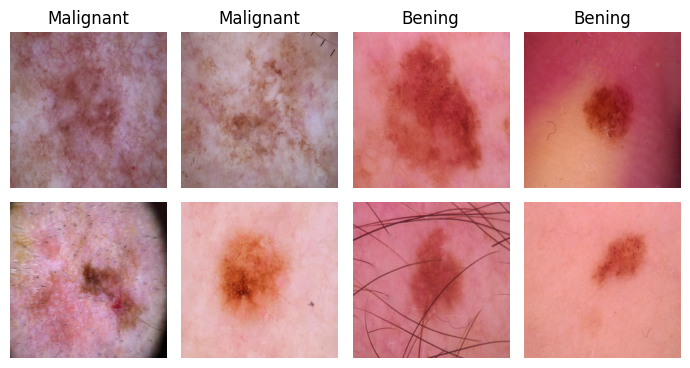


Image width: 224px
Image height: 224px
Image number of channels: 3


In [154]:
# change to 3x3

fig, axs = plt.subplots(2,4, figsize=(7,7), dpi=100)
k = 0
for i in range(2):
  for j in range(2):
    img_malignant = plt.imread(malignant_paths_train[k])[:,:,:3]
    img_bening = plt.imread(bening_paths_train[k])[:,:,:3]
    axs[i,j].imshow(img_malignant)
    axs[i,j+2].imshow(img_bening)
    axs[i,j].axis('off')
    axs[i,j+2].axis('off')
    k += 1

axs[0,0].set_title('Malignant')
axs[0,1].set_title('Malignant')
axs[0,2].set_title('Bening')
axs[0,3].set_title('Bening')

fig.tight_layout(h_pad=-15)
#fig.suptitle('Malignant - train', size=15)
plt.show()

img_height,img_width,img_channels = img_malignant.shape

print('\nImage width: {}px\nImage height: {}px\nImage number of channels: {}'.format(img_height, img_width,img_channels))

In [155]:
# Model definition

from tensorflow import keras
from keras.layers import Input, Rescaling, Conv2D, MaxPool2D, Flatten, Dense

model = keras.Sequential([
    Input((img_height,img_width,img_channels)),
    Rescaling(1./255),
    Conv2D(3,(3,3), padding='same'),
    Conv2D(3, (3,3), padding='same'),
    MaxPool2D(),
    Conv2D(6,(3,3), padding='same'),
    Conv2D(6,(3,3), padding='same'),
    MaxPool2D(),
    Conv2D(12,(3,3), padding='same'),
    Conv2D(12,(3,3), padding='same'),
    MaxPool2D(),
    Conv2D(24,(3,3), padding='same'),
    Conv2D(24,(3,3), padding='same'),
    MaxPool2D(),
    Conv2D(48,(3,3), padding='same'),
    Conv2D(48,(3,3), padding='same'),
    MaxPool2D(),
    Flatten(),
    Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_188 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 conv2d_189 (Conv2D)         (None, 224, 224, 3)       84        
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 112, 112, 3)      0         
 g2D)                                                            
                                                                 
 conv2d_190 (Conv2D)         (None, 112, 112, 6)       168       
                                                                 
 conv2d_191 (Conv2D)         (None, 112, 112, 6)       330       
                                                     

In [156]:
# Training

#change batch_size

train_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/skin_cancer_small/train',
    validation_split=0.2,
    seed=1,
    image_size=(img_height,img_width),
    subset='training',
    batch_size=2
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/skin_cancer_small/train',
    validation_split=0.2,
    seed=1,
    image_size=(img_height,img_width),
    subset='validation',
    batch_size=2
)

Found 10 files belonging to 2 classes.
Using 8 files for training.
Found 10 files belonging to 2 classes.
Using 2 files for validation.


In [202]:
class PlotLosses(keras.callbacks.Callback):
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.recalls = []
        self.val_recalls = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        val_recall = [x for x in list(logs.keys()) if x.startswith('recall')][0]
        val_recall_key = [x for x in list(logs.keys()) if x.startswith('val_recall')][0]
        self.recalls.append(logs.get(val_recall))
        self.val_recalls.append(logs.get(val_recall_key))

        #print('Logs keys',logs.keys())

        #recall = logs.get('true_positives') / (logs.get('true_positives')+logs.get('false_positives')

        self.i += 1
        
        clear_output(wait=True)
        
        # add here model prediction and title with probability 
        # of it - one for malignant and one for bening from validation dataset
        fig, axs = plt.subplots(1,2,figsize=(16,4), dpi=100)
        axs[0].set_xlim([0,self.n_epochs-1])
        axs[1].set_xlim([0,self.n_epochs-1])
        axs[0].plot(self.x, self.losses, label="Training loss")
        axs[0].plot(self.x, self.val_losses, label="Validaiton loss")
        axs[1].plot(self.x, self.recalls, label="Training recall")
        axs[1].plot(self.x, self.val_recalls, label="Validation recall")
        axs[0].set_title('Loss')
        axs[1].set_title('Recall')
        #axs.set_title(logs.keys())
        axs[0].legend()
        axs[1].legend()
        plt.show();

In [203]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), AUC(), FalseNegatives(), FalsePositives(), TrueNegatives(), TruePositives(), Recall()],
)

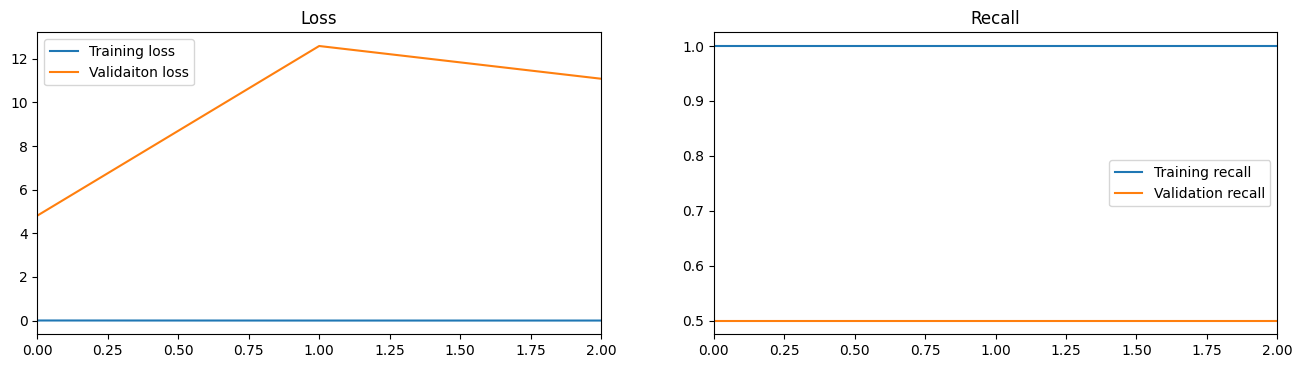

4/4 [==============================] - 1s 218ms/step - loss: 2.2708e-04 - binary_accuracy: 1.0000 - auc_25: 1.0000 - false_negatives_26: 0.0000e+00 - false_positives_26: 0.0000e+00 - true_negatives_25: 5.0000 - true_positives_25: 3.0000 - recall_4: 1.0000 - val_loss: 11.0852 - val_binary_accuracy: 0.5000 - val_auc_25: 0.0000e+00 - val_false_negatives_26: 1.0000 - val_false_positives_26: 0.0000e+00 - val_true_negatives_25: 0.0000e+00 - val_true_positives_25: 1.0000 - val_recall_4: 0.5000


In [204]:
N_EPOCHS = 3

plot_losses = PlotLosses(n_epochs=N_EPOCHS)

history = model.fit(train_data, 
          validation_data=validation_data, 
          epochs=N_EPOCHS,
          callbacks=[plot_losses]
          )

In [205]:
# Testing

# AUC(), FalseNegatives(), FalsePositives(), TrueNegatives(), TruePositives()

test_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/skin_cancer_small/test',
    seed=1,
    image_size=(img_height,img_width),
    batch_size=2
)

model_evaluation = model.evaluate(test_data)

Found 10 files belonging to 2 classes.
5/5 [==============================] - 0s 41ms/step - loss: 10.6729 - binary_accuracy: 0.5000 - auc_25: 0.5200 - false_negatives_26: 5.0000 - false_positives_26: 0.0000e+00 - true_negatives_25: 5.0000 - true_positives_25: 0.0000e+00 - recall_4: 0.0000e+00


In [206]:
model_evaluation

[10.672897338867188, 0.5, 0.5200000405311584, 5.0, 0.0, 5.0, 0.0, 0.0]

In [ ]:
# Layer's visualization, examples of good and bad predictions

# https://www.youtube.com/watch?v=cNBBNAxC8l4

In [ ]:
# Dark skin 